<a href="https://colab.research.google.com/github/Pager07/TensorflowSpecialization/blob/master/C4W2-LrSechudelerCallbackAndTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Creating Time Series Data (Given)

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

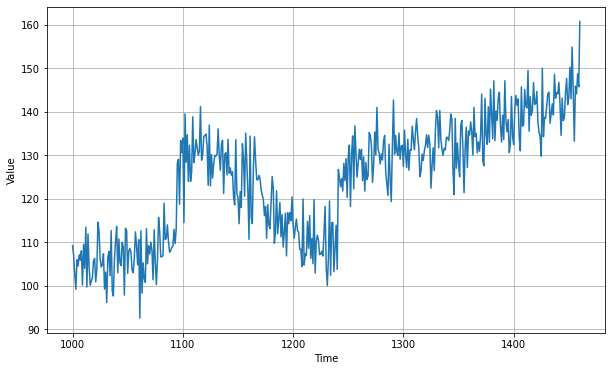

In [3]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)

In [19]:
def windowed_dataset(series,window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift = 1 , drop_remainder= True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1],window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset 

#Model (Constant LR)

In [22]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [24]:

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(units=10, input_shape=[window_size],activation='relu'),
                                    tf.keras.layers.Dense(units=10, activation='relu'),
                                    tf.keras.layers.Dense(1)

])

model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

#Inference

(461, 1, 1)
(461,)


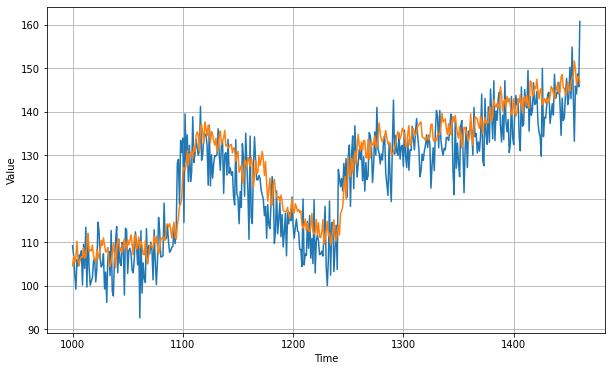

In [27]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size].reshape(1,-1))) #After first go forecast = [[y_hat]]

forecast = forecast[split_time - window_size:]
print(np.array(forecast).shape)
print( np.array(forecast).flatten().shape)
results = np.array(forecast).flatten()

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

5.2166185

#Model (LR sechudluer)

In [39]:
dataset = windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10,input_shape=[window_size], activation='relu'),
                                    tf.keras.layers.Dense(10,activation='relu'),
                                    tf.keras.layers.Dense(1)
])

#Every epoch, this callback will change it value based on the epoch we are 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss='mse',optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule],verbose=0)


(1e-08, 0.001, 0.0, 300.0)

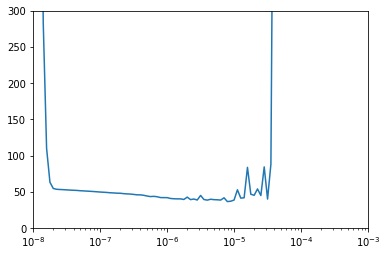

In [43]:
#Lets plot the lr and it's corresponding loss
# A list of all the lrs we tried
lrs = 1e-8 * (10 **(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])

#plt.plot(lrs,history.history["loss"])
# we can zoomin to part of the graph by giving custom axis values
#[x_start,x_end,y_start, y_end]
plt.axis([1e-8,1e-3,0,300])

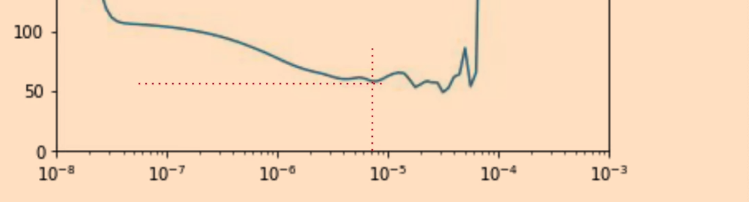

Example in video: "We can then try to pick the lowest point of the curve where it's still relatively stable like this, and that's right around 7x10^(-6) or 7e-6."

In [49]:
#Now use the best lr 
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

[44.84788131713867, 42.21001434326172, 41.46269226074219, 39.07051467895508, 40.91462326049805, 53.485618591308594, 41.836177825927734, 37.913116455078125, 37.91699981689453, 44.02882385253906, 36.6684455871582, 36.689456939697266, 36.670745849609375, 37.796844482421875, 40.66720199584961, 39.44837188720703, 36.19060134887695, 36.69622039794922, 38.08491897583008, 35.805419921875, 39.73871612548828, 40.49247360229492, 36.89888381958008, 37.51582336425781, 37.257789611816406, 36.155906677246094, 47.194801330566406, 37.69287872314453, 50.55829620361328, 44.62718963623047, 36.8284797668457, 36.34917068481445, 38.182674407958984, 42.75648498535156, 41.07424545288086, 54.54983901977539, 38.22724151611328, 34.38783645629883, 37.41486740112305, 37.70863342285156, 37.25620651245117, 36.01115798950195, 38.85648727416992, 35.86450958251953, 35.72126770019531, 36.12757110595703, 38.011619567871094, 36.76566696166992, 36.83062744140625, 48.090904235839844, 35.06135177612305, 39.09868621826172, 37.

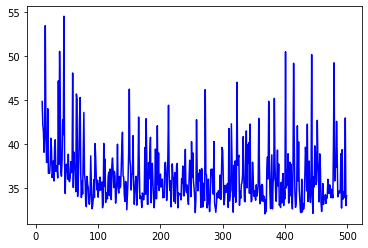

In [51]:
loss = history.history['loss']
epochs = range(10,len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs,plot_loss,'b',label='Training Loss')
plt.show()

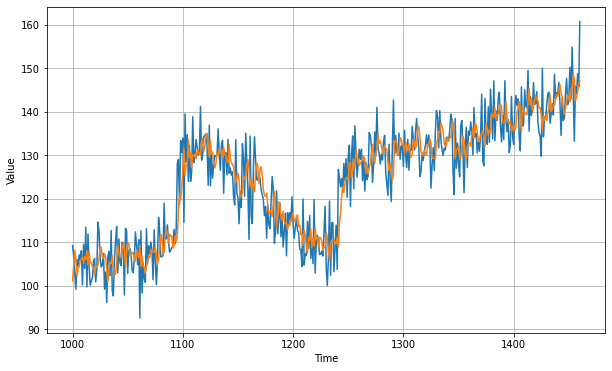

In [52]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size].reshape(1,-1)))

forecast = forecast[split_time - window_size:]
results = np.array(forecast).flatten()

plt.figure(figsize=(10,6))

plot_series(time_valid,x_valid)
plot_series(time_valid,results)

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5962486